# 1. Packages import

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from textwrap import wrap
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pyodbc 

np.seterr(all='ignore') 

%matplotlib inline

# 2. Data retrieval

In [2]:
datetime.now()

datetime.datetime(2018, 12, 20, 15, 0, 5, 343358)

In [3]:
# Asia index mmapping
def clean_sheet(dataframe):
    adj=dataframe.dropna(axis=1,how='all')
    adj=dataframe.set_index(adj.columns[0]) #use stock tickers as the index
    return adj


Asia_mapping=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result data\{0} 2007-2017.xlsx'.format('Asia'),\
                                       sheet_name='Mapping'))

In [4]:
'''Connect to post result SQL server'''
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=dsa-ln-WS015\SQLEXPRESS;DATABASE=Post_result;Trusted_Connection=yes')   
cursor = cnxn.cursor()

In [5]:
def SQL_price_date_transform(SQL_date,index=False):
    '''
    Transform the SQL price style string into dateframe string style
    The SQL price follows US style which is MM DD YYYY
    '''
    if index==False:
        timestamp=pd.Timestamp(int(SQL_date[SQL_date.find(" ",3):]),
                            int(SQL_date[:SQL_date.find(" ")]),
                            int(SQL_date[SQL_date.find(" ",1):SQL_date.find(" ",3)]))
        return timestamp.strftime("%d/%b/%Y")
    else:
        timestamp=pd.Timestamp(int(SQL_date[-4:]),int(SQL_date[3:5]),int(SQL_date[:2]))
        return timestamp

In [6]:
def SQL_fundamental_date_transform(SQL_date):
    '''
    Transform the SQL fundamental style string into dateframe string style
    '''
    timestamp=pd.Timestamp(int(SQL_date[:4]),
                        int(SQL_date[5:7]),
                        int(SQL_date[8:]))
    return timestamp

In [7]:
def SQL_price(region,start,end):
    '''
    Grab the pricing data from SQL database
    region= US, Europe,Asia,or Canada
    start,end are in year
    key is the reference to search
    return the target price dataframe with timestamp on the column
    '''
    mylist=[]
    for year in range(start,end+1):
        sql="select * from {0}_price_{1}".format(region,year)
        data=pd.read_sql(sql,cnxn).set_index("Ticker")
        adj_data=data.loc[[x for x in data.index if len(x)>0]].replace('#N/A N/A','')
        mylist.append(adj_data)

    price=pd.concat(mylist,axis=1)
    price=price.apply(lambda x:pd.to_numeric(x),axis=1)
    
    sql_index="select * from {0}_price_index".format(region)
    data_index=pd.read_sql(sql_index,cnxn).set_index("Ticker").T
    data_index=data_index.replace('#N/A N/A','')
    price_index=data_index.apply(lambda x:pd.to_numeric(x),axis=1)
    
    price.columns=[SQL_price_date_transform(i) for i in price.columns]
    '''
    Need to sort the columns for index price, and then transform to date string
    '''
    price_index.columns=[SQL_price_date_transform(i,index=True) for i in price_index.columns]
    price_index=price_index.reindex(sorted(price_index.columns), axis=1)
    price_index.columns=[i.strftime("%d/%b/%Y") for i  in price_index.columns]
    
    abs_return=price.diff(1,axis=1)/price.shift(1,axis=1)
    abs_return_index=price_index.diff(1,axis=1)/price_index.shift(1,axis=1)
    return price,abs_return,price_index,abs_return_index

In [8]:
def SQL_fundamentals(region,abs_return):
    '''
    Grab the fundamental data from SQL database
    region= US, Europe,Asia,or Canada
    return the post result fundamental dataframe
    '''
    sql="select * from {0}".format(region)
    data=pd.read_sql(sql,cnxn).set_index("Ticker").drop_duplicates().replace('#N/A Invalid Security','')
    
    data=data[data.index!='']
    
    data["Date"]=[SQL_fundamental_date_transform(i) for i in data["Date"]]
    data["ticker_copy"]=data.index
    data=data.sort_values(by=["ticker_copy","Date"])
    data["next_date"]=data["Date"].shift(-1)
    data["ticker_copy"]=data["ticker_copy"].shift(-1)
    data["Date"]=data["Date"].apply(lambda x: x.strftime("%d/%b/%Y") if x!='' else np.nan)
    data["Next"]=data.apply(lambda x: x["next_date"].strftime("%d/%b/%Y") if x.name==x["ticker_copy"] else np.nan,axis=1)

    del data["ticker_copy"]
    del data["next_date"]
     
    data.index=pd.MultiIndex.from_tuples(data.apply(lambda x:(x.name,x["Date"],x["Next"]),axis=1))
    
    for s in ["Revision","Revision vol","Market cap","Volume"]:
        try:
            data[s]=pd.to_numeric(data[s])
        except KeyError:
            pass
            
    
    '''
    take out data with zero or none revision
    '''
    data=data[(data["Revision"]>0)|(data["Revision"]<0)]
    
    if 'Revision vol' in data.columns:
        data=data[(data["Revision vol"]>0)|(data["Revision vol"]<0)]
        data["Revision_norm"]=data.apply(lambda x: x["Revision"]/x["Revision vol"] if x["Revision vol"]!=0 else None,axis=1)
    
    
    data["30d_vol"]=data.apply(lambda x: abs_return.loc[x.name[0],:x.name[1]][-31:-1].std() if x.name[1] in abs_return.columns\
                               else None,axis=1)
    
    
    return data

In [9]:
US_price,abs_return_US,US_index_price,abs_return_index_US=SQL_price('US',2006,2017)

In [10]:
US=SQL_fundamentals("US",abs_return_US)

In [11]:
Asia_price,abs_return_Asia,Asia_index_price,abs_return_index_Asia=SQL_price('Asia',2007,2017)

In [12]:
Asia=SQL_fundamentals("Asia",abs_return_Asia)

In [13]:
Europe_price,abs_return_Europe,Europe_index_price,abs_return_index_Europe=SQL_price('Europe',2006,2017)

In [14]:
Europe=SQL_fundamentals("Europe",abs_return_Europe)

# 3. Utility functions

In [15]:
def EAR_calc(ticker,date,return_df,EAR_period,vol_lookback):
    '''
    Calculate EAR from ticker and reference date
    '''
    if type(date)==pd._libs.tslib.NaTType:
        return None
    elif type(date)==pd._libs.tslib.Timestamp:
        date=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        date=date
    return_series=return_df.loc[ticker].dropna()
    date_series=return_series.index.tolist()
    if date in date_series:
        day0=date_series.index(date)
        post_series=return_series.iloc[day0:]
        pre_series=return_series.iloc[:day0]
        vol= return_series.iloc[day0-min(len(pre_series),vol_lookback+1):day0].std()
        ret=(return_series.iloc[day0:day0+EAR_period]+1).prod()-1
        nmove=ret/vol
        return nmove
    else:
        return None

In [16]:
def signal_vol(signal_column,return_df,vol_lookback):
    '''
    Calculate simple vol from signal tuple
    '''
    signal_series=return_df.loc[signal_column.name[0]]
    location=signal_series.index.tolist().index(signal_column.name[1])
    vol_range=min(vol_lookback,len(signal_series[:location]))
    signal_vol=signal_series[location-vol_range-1:location].std()
    return signal_vol

In [17]:
def slice_universe(signal_df,start_datetime,end_datetime):
    '''
    Slice the signal_df, both the index and entry date have to be 
    '''
    
    entry=signal_df.apply(lambda x:datetime.strptime(x.name[1],"%d/%b/%Y"),axis=0)
    period_evaluate=(entry>=start_datetime)&(entry<=end_datetime)
    adj_signal_df=signal_df.loc[:,period_evaluate]
    adj_signal_df=adj_signal_df.loc[start_datetime:end_datetime]
    
    zero_index=pd.date_range(start_datetime,end_datetime,freq='B').to_frame()
    adj_signal_df=pd.concat([adj_signal_df,zero_index],axis=1).iloc[:,:-1]
    return adj_signal_df
    

In [18]:
def signal_filter_stop(signal_df,stop_level,return_df,vol_lookback):
    '''
    Input - signal_df
    Get the updated signal df after the stop loss
    '''
    
    vol_row=signal_df.apply(lambda column:signal_vol(column,return_df,vol_lookback),axis=0)
    signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/vol_row
    signal_df_stop=signal_df[-(signal_cum_nmove.expanding().min().shift(1,axis=0)<-stop_level)]
    return signal_df_stop

In [19]:
def sizing(signal_df,reference,gross,fundamental_df,return_df,risk_parity,liquidity,capital):
    '''
    Use historical signal_df range to calculate the size row for the current signal_df range
    Idea is to use historical as a benchmark for future sizing
    '''
    number=reference.count(axis=1).mean()
    avg_size=gross/100/number
    vol_reference=reference.apply(lambda column:signal_vol(column,return_df,30),axis=0).mean()
    vol_row=signal_df.apply(lambda column:signal_vol(column,return_df,30),axis=0)
    
    fundamental_df=fundamental_df.sort_index()
    if risk_parity is True:
        size_row=signal_df.apply(lambda x: min(avg_size/(vol_row[x.name]/vol_reference),\
                                               fundamental_df.loc[x.name[0],x.name[1]]["Volume"].iloc[0]*\
                                               liquidity/capital),axis=0)
    else:
        size_row=signal_df.apply(lambda x: min(avg_size, fundamental_df.loc[x.name[0],x.name[1]]["Volume"].iloc[0]\
                                               *liquidity/capital),axis=0)
    return size_row

In [20]:
def trading_analytics_date(portfolio_cache):
    '''
    Key portfolio metrics from portfolio cache
    Feed into plot function
    '''
    
    ind_return=portfolio_cache[3]
    signal_count=len(ind_return)
    account_curve=portfolio_cache[1]
    
    if signal_count==0:
        return None,None,None,None,None,None,None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        
        account_price=account_curve+1
        ann_vol=np.std(account_price.diff()/account_price.shift(1))*(260**0.5)
        ann_ret=np.mean(account_price.diff()/account_price.shift(1))*260
        ann_sharpe=ann_ret/ann_vol
        
        max_dd=-((1+account_curve)/(1+account_curve).cummax(axis=0)-1).expanding().min().min()
        
        #low_date=(np.maximum.accumulate(account_curve)-account_curve).idxmax()
        #high_date=account_curve[:low_date].idxmax()
        #max_dd=1-(1+account_curve[low_date])/(1+account_curve[high_date])
        
        return signal_count,hit_rate,payoff_ratio,ann_ret,ann_vol,ann_sharpe,max_dd

In [21]:
def plot_signal(title,figsize,portfolio_cache):

    account_curve=portfolio_cache[1]
    avg_size=np.abs(portfolio_cache[2]).mean(axis=0).mean()
    ind_return=portfolio_cache[3]
    gross=portfolio_cache[4]
    turnover=portfolio_cache[5]

    fig=plt.figure(figsize=figsize)
    ax1=fig.add_subplot(1,1,1)
    ln1=ax1.plot(account_curve,label='signal',color='b')

    val1=ax1.get_yticks()
    start=val1[0]
    end=val1[-1]
    ax1.set_yticks(np.arange(start,end,0.1))  
    adj_val1=ax1.get_yticks()
    ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])

    ax2=ax1.twinx()
    ln2=ax2.plot(gross,label='gross',color='silver')

    val2=ax2.get_yticks()
    start=val2[0]
    end=val2[-1]
    ax2.set_yticks(np.arange(start,end,0.1))  
    adj_val2=ax2.get_yticks()
    ax2.set_yticklabels(["{:.0%}".format(x) for x in adj_val2])

    count,hit,payoff,ret,vol,sharpe,max_dd=trading_analytics_date(portfolio_cache)

    plt.title("\n".join(wrap('count='+str(count)+
                             ',avg_size='+str("{:.1%}".format(avg_size))+
                             ',hit_rate='+str("{:.0%}".format(hit))+
                             ',payoff='+str(round(payoff,1))+
                             ',return='+str("{:.1%}".format(ret))+
                             ',vol='+str("{:.1%}".format(vol))+
                             ',sharpe='+str(round(sharpe,1))+
                             ',turnover='+str(round(turnover,1))+'x'+                             
                             ',max_drawdown='+str("{:.1%}".format(max_dd)))),fontsize=10)

    ax1.set_xlabel('Year')
    ax1.set_ylabel('Return')
    ax2.set_ylabel('Exposure')
    plt.suptitle(title,y=1.05,fontsize=16)
    plt.grid(linestyle='dashed')
    plt.legend(ln1+ln2,[l.get_label() for l in ln1+ln2])
    ax1.axhline(y=0,color='k')

    plt.show()        

# 4. Signal class 

In [45]:
class signal(object):
    '''
    Signal class is built to initialize the signal_df and account curve from base parameters 
    '''
    def __init__(self,fundamental_df,price_df,EAR_period,long_criteria,short_criteria,holding,start,end):
        '''
        Define the key free parameters of the signal
        Criteria:(EAR,revision,revision_norm,size)
        '''
        self.fundamental_df=fundamental_df
        self.price_df=price_df
        self.abs_return=price_df.diff(1,axis=1)/price_df.shift(1,axis=1)
        self.EAR_period=EAR_period
        self.long_criteria=long_criteria
        self.short_criteria=short_criteria
        self.holding=holding
        self.start=start
        self.end=end
        
    def signal_base(self):
        '''
        Filter the signal criteria like EAR and revision, get the target signal list
        From the fundamental information
        For both long and short side
        '''
        
        long_base=self.fundamental_df.copy()
        short_base=self.fundamental_df.copy()
        
        if self.long_criteria is None:
            long_base=None
        else:
            
            if self.long_criteria[1] is None:
                pass
            else:
                long_base=long_base[(long_base["Revision"]>self.long_criteria[1][0])\
                                                    &(long_base["Revision"]<self.long_criteria[1][1])]

            if self.long_criteria[2] is None:
                pass
            else:
                long_base=long_base[(long_base["Revision_norm"]>self.long_criteria[2][0])\
                                                    &(long_base["Revision_norm"]<self.long_criteria[2][1])]
                
            if self.long_criteria[3] is None:
                pass
            else:
                long_base=long_base[(long_base["Market cap"]>self.long_criteria[3][0])&\
                                        (long_base["Market cap"]<self.long_criteria[3][1])]
            
            if self.long_criteria[0] is None:
                pass
            else:
            
                long_base["EAR"]=long_base.apply(lambda x:EAR_calc(x.name[0],x.name[1],self.abs_return,self.EAR_period,30)\
                                             if x.name[0] in self.abs_return.index else None,axis=1)

                long_base=long_base[(long_base["EAR"]>self.long_criteria[0][0])&(long_base["EAR"]<self.long_criteria[0][1])]
                
                
        if self.short_criteria is None:
            short_base=None
        else:
            
            if self.short_criteria[1] is None:
                pass
            else:
                short_base=short_base[(short_base["Revision"]>self.short_criteria[1][0])\
                                                    &(short_base["Revision"]<self.short_criteria[1][1])]

            if self.short_criteria[2] is None:
                pass
            else:
                short_base=short_base[(short_base["Revision_norm"]>self.short_criteria[2][0])\
                                                    &(short_base["Revision_norm"]<self.short_criteria[2][1])]
                
            if self.short_criteria[3] is None:
                pass
            else:
                short_base=short_base[(short_base["Market cap"]>self.short_criteria[3][0])&\
                                        (short_base["Market cap"]<self.short_criteria[3][1])]
            
            if self.short_criteria[0] is None:
                pass
            else:
            
                short_base["EAR"]=short_base.apply(lambda x:EAR_calc(x.name[0],x.name[1],self.abs_return,self.EAR_period,30)\
                                             if x.name[0] in self.abs_return.index else None,axis=1)

                short_base=short_base[(short_base["EAR"]>self.short_criteria[0][0])&\
                                      (short_base["EAR"]<self.short_criteria[0][1])]
                
        return long_base,short_base
    
    def signal_df_date(self):#if we hold them through next earning
        '''
        Obtain the signal_df function over the whole time period from the target signal list
        '''
        long_base,short_base=signal.signal_base(self)
        
        if long_base is None:
            long_df=None
            self.long_df=None
        
        else:
            long_df=pd.DataFrame(index=self.price_df.columns)

            for s in long_base.index:
                return_series=self.abs_return.loc[s[0]]
                if s[1] in return_series.index:
                    if not np.isnan(return_series.loc[s[1]]): 
                        day0=return_series.index.tolist().index(s[1])
                        if type(s[2])==float:##basically np.nan has type float
                            period=self.holding
                        else: ##assume that we are not holding through numbers
                            period=min(self.holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),\
                                                                    datetime.strptime(s[2],"%d/%b/%Y"))-self.EAR_period)\
                            #EAR period as entry
                        target_series=return_series.iloc[day0+self.EAR_period-1:day0+min(period+self.EAR_period, \
                                                                                       len(return_series[day0:]))].dropna()
                        if len(target_series)==0:
                            pass
                        else:
                            target_series.iloc[0]=0.0
                            long_df[s]=target_series                        

            long_df=long_df.reindex(datetime.strptime(i,"%d/%b/%Y") for i in long_df.index)

            if self.start is not None:
                long_df=slice_universe(long_df,self.start,self.end)
            else:
                pass
            
            long_df=long_df.dropna(how="all",axis=1)
            long_df.columns=pd.MultiIndex.from_tuples(pd.Series(list(long_df.columns)))
            self.long_df=long_df
            
            
        
        if short_base is None:
            short_df=None
            self.short_df=None
        
        else:
            short_df=pd.DataFrame(index=self.price_df.columns)

            for s in short_base.index:
                return_series=self.abs_return.loc[s[0]]
                if s[1] in return_series.index:
                    if not np.isnan(return_series.loc[s[1]]): 
                        day0=return_series.index.tolist().index(s[1])
                        if type(s[2])==float:##basically np.nan has type float
                            period=self.holding
                        else: ##assume that we are not holding through numbers
                            period=min(self.holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),\
                                                                    datetime.strptime(s[2],"%d/%b/%Y"))-self.EAR_period)\
                            #EAR period as entry
                        target_series=return_series.iloc[day0+self.EAR_period-1:day0+min(period+self.EAR_period, \
                                                                                       len(return_series[day0:]))].dropna()
                        if len(target_series)==0:
                            pass
                        else:
                            target_series.iloc[0]=0.0
                            short_df[s]=target_series                        

            short_df=short_df.reindex(datetime.strptime(i,"%d/%b/%Y") for i in short_df.index)

            if self.start is not None:
                short_df=slice_universe(short_df,self.start,self.end)
            else:
                pass  
            
            short_df=short_df.dropna(how="all",axis=1)
            short_df.columns=pd.MultiIndex.from_tuples(pd.Series(list(short_df.columns)))
            self.short_df=short_df
        
        return long_df,short_df

    def signal_account(self,stop,gross,index_df,net_level,risk_parity,liquidity,capital):
        '''
        Build the account curve with signal_df
        Assume quarterly rebalancing that's why the period list has quarter as the key
        Take extra care when building the account curve, the logic is: work out the size_df, then shift by 1 and * signal_df
        Stop=(long_stop,short_stop)
        '''
        
        try:
            long_df=self.long_df.copy()
            short_df=self.short_df.copy()
            
        except AttributeError:
            long_df,short_df=signal.signal_df_date(self)
                   
        '''
        Assign values for later use
        '''
        
        self.capital=capital
        
        self.index_df=index_df
        self.index_df.index=[datetime.strptime(i,"%d/%b/%Y") for i in self.index_df.index]
       
        
        '''
        Define rebalance period first
        '''
        period=long_df.apply(lambda x:str(x.name.year)+" "+str(x.name.quarter),axis=1)
        period_list=list(set(period))
        period_list.sort()    
        
        '''
        Separate out long and short
        '''
        if long_df is None:
            long_cache=(None,None,None,None)
        else:
            if stop is None:
                pass
            else:
                long_df=signal_filter_stop(long_df,stop[0],self.abs_return,30)   

            long_sub_signal={}
            long_sub_size_row={}
            long_sub_size_df={}
            long_sub_pnl={}
        
            for s in period_list:
                long_sub_signal[s]=long_df[period==s].dropna(how='all',axis=1)
                if period_list.index(s)<4:##use last quarter's sizing as reference
                    long_sub_size_row[s]=sizing(long_sub_signal[s],long_sub_signal[s],gross[0],self.fundamental_df,\
                                                   self.abs_return,risk_parity,liquidity,capital)
                else:
                    long_sub_size_row[s]=sizing(long_sub_signal[s],long_sub_signal[period_list[period_list.index(s)-1]],\
                                                   gross[0],self.fundamental_df,self.abs_return,risk_parity,liquidity,capital)
                long_sub_size_df[s]=(1+long_sub_signal[s]).cumprod()*long_sub_size_row[s]
                long_sub_pnl[s]=(long_sub_size_df[s].shift(1))*long_sub_signal[s] 
                # need to shift by 1 as the size is end of the day
        
            long_daily_pnl=pd.concat(list(long_sub_pnl.values()),axis=0)
            long_acct_curve=long_daily_pnl.cumsum().ffill().sum(axis=1)
            long_size_df=pd.concat(list(long_sub_size_df.values()),axis=0)
            long_ind_return=long_daily_pnl.cumsum().ffill().iloc[-1].dropna()
            long_cache=(long_daily_pnl,long_acct_curve,long_size_df,long_ind_return)

            
        if short_df is None:
            short_cache=(None,None,None,None)
        else:
            if stop is None:
                pass
            else:
                short_df=-signal_filter_stop(-short_df,stop[1],self.abs_return,30)   

            short_sub_signal={}
            short_sub_size_row={}
            short_sub_size_df={}
            short_sub_pnl={}
        
            for s in period_list:
                short_sub_signal[s]=short_df[period==s].dropna(how='all',axis=1)
                if period_list.index(s)<4:##use last quarter's sizing as reference
                    short_sub_size_row[s]=-sizing(short_sub_signal[s],short_sub_signal[s],gross[1],self.fundamental_df,\
                                                   self.abs_return,risk_parity,liquidity,capital)
                else:
                    short_sub_size_row[s]=-sizing(short_sub_signal[s],short_sub_signal[period_list[period_list.index(s)-1]],\
                                                   gross[1],self.fundamental_df,self.abs_return,risk_parity,liquidity,capital)
                short_sub_size_df[s]=(1+short_sub_signal[s]).cumprod()*short_sub_size_row[s]
                short_sub_pnl[s]=(short_sub_size_df[s].shift(1))*short_sub_signal[s] 
                # need to shift by 1 as the size is end of the day
        
            short_daily_pnl=pd.concat(list(short_sub_pnl.values()),axis=0)
            short_acct_curve=short_daily_pnl.cumsum().ffill().sum(axis=1)
            short_size_df=pd.concat(list(short_sub_size_df.values()),axis=0)
            short_ind_return=short_daily_pnl.cumsum().ffill().iloc[-1].dropna()
            
            short_cache=(short_daily_pnl,short_acct_curve,short_size_df,short_ind_return)
    
        '''Put alpha positions together to form the alpha part'''
        alpha_df=pd.concat([long_df,short_df],axis=1)
        self.alpha_df=alpha_df
        
        alpha_daily_pnl=pd.concat([long_cache[0],short_cache[0]],axis=1)
        alpha_acct_curve=alpha_daily_pnl.cumsum().ffill().sum(axis=1)
        alpha_size_df=pd.concat([long_cache[2],short_cache[2]],axis=1)
        alpha_ind_return=pd.concat([long_cache[3],short_cache[3]],axis=0)
        
        alpha_cache=(alpha_daily_pnl,alpha_acct_curve,alpha_size_df,alpha_ind_return)
        
        
        if self.index_df is not None:
            if self.index_df.shape[1]==1:
                index_df=self.index_df.copy().loc[alpha_df.index] 
                index_size_df=(net_level-alpha_size_df.sum(axis=1)).to_frame(index_df.columns[0])
                index_daily_pnl=index_size_df.shift(1)*index_df
                index_acct_curve=index_daily_pnl.cumsum()
                index_ind_return=index_acct_curve.iloc[-1]
                index_cache=(index_daily_pnl,index_acct_curve,index_size_df,index_ind_return)
            else:
                index_df=self.index_df.copy().loc[alpha_df.index] 
                alpha_temp=alpha_cache[2].copy().T
                alpha_temp["index"]=alpha_temp.apply(lambda x:Asia_mapping.loc[x.name[0][-2:]].iloc[0],axis=1)
                index_size_df=net_level-alpha_temp.groupby("index").apply(sum).T.iloc[:-1]
                index_daily_pnl=index_size_df.shift(1)*index_df
                index_acct_curve=index_daily_pnl.cumsum()
                index_ind_return=index_acct_curve.iloc[-1]
                index_cache=(index_daily_pnl,index_acct_curve,index_size_df,index_ind_return)
        else:
            index_cache=(None,None,None,None)
            
        '''Finally put everything together'''    
        portfolio_df=pd.concat([alpha_df,index_df],axis=1)
            
        portfolio_size_df=pd.concat([alpha_cache[2],index_cache[2]],axis=1)
  
        portfolio_daily_pnl=pd.concat([alpha_cache[0],index_cache[0]],axis=1)

        portfolio_acct_curve=portfolio_daily_pnl.cumsum().ffill().sum(axis=1)
        portfolio_ind_return=alpha_cache[3].copy()
        
        portfolio_gross=np.abs(portfolio_size_df).sum(axis=1)
        portfolio_turnover=(np.abs(alpha_size_df.fillna(0.0).diff(1)).sum().sum())/(portfolio_size_df.shape[0]/260)
        
        portfolio_cache=(portfolio_daily_pnl,portfolio_acct_curve,portfolio_size_df,portfolio_ind_return,portfolio_gross,\
                         portfolio_turnover,portfolio_df)
        
        self.portfolio_account=portfolio_cache #save for later use
        
        
        return long_cache,short_cache,alpha_cache,portfolio_cache
    
    def plot_account(self,title,figsize=[6,4],portfolio=None):
        '''
        Plot the account curve
        '''
        if portfolio is None:
            try:
                portfolio_cache=self.portfolio_account

            except AttributeError:
                print("Execute the signal_account first!")  
                return None
        else:
            portfolio_cache=portfolio
        
        plot_signal(title,figsize,portfolio_cache)

In [62]:
def combine_signal(portfolio_list,capital_list):
    
    
    daily_pnl_list=[]
    signal_df_list=[]
    portfolio_size_list=[]
    for i in range(len(portfolio_list)):

        daily_pnl_list.append(portfolio_list[i][0]*capital_list[i]/np.sum(capital_list))
        signal_df_list.append(portfolio_list[i][-1]*capital_list[i]/np.sum(capital_list))
        portfolio_size_list.append(portfolio_list[i][2]*capital_list[i]/np.sum(capital_list))
    
    daily_pnl=pd.concat(daily_pnl_list,axis=1)
    signal_df=pd.concat(signal_df_list,axis=1)
    size_df=pd.concat(portfolio_size_list,axis=1)
    
    account_curve=daily_pnl.cumsum().ffill().sum(axis=1)
    ind_return=daily_pnl.cumsum().ffill().iloc[-1]

    gross=np.abs(size_df).sum(axis=1)
    turnover=(np.abs(size_df.fillna(0.0).diff(1)).sum().sum())/(size_df.shape[0]/260)
    
    portfolio_cache=(daily_pnl,account_curve,size_df,ind_return,gross,turnover,signal_df)
    return portfolio_cache


In [63]:
aa=combine_signal(portfolio_list=[_portfolio,_portfolio_Europe,_portfolio_Asia],
                    capital_list=[50,50,50])

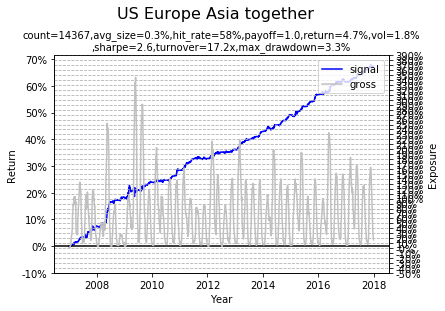

In [67]:
plot_signal('US Europe Asia together',[6,4],aa)

In [22]:
datetime.now()

datetime.datetime(2018, 12, 17, 8, 5, 44, 916836)

In [46]:
Europe_day2_30d=signal(fundamental_df=Europe,
                   price_df=Europe_price,
                   EAR_period=2,
                   long_criteria=((1,1000),(0.03,1000),None,None),
                   short_criteria=((-1000,-2),(-1000,-0.03),None,(5000,10000000)),
                   holding=30,
                   start=pd.Timestamp(2007,1,1),
                   end=pd.Timestamp(2017,12,31))

In [47]:
_long_Europe,_short_Europe,_alpha_Europe,_portfolio_Europe=Europe_day2_30d.signal_account(stop=(8,8),
                                                           gross=(30,15),
                                                           index_df=abs_return_index_Europe.loc["SX5E Index"].to_frame('Europe'),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.1,
                                                           capital=60)

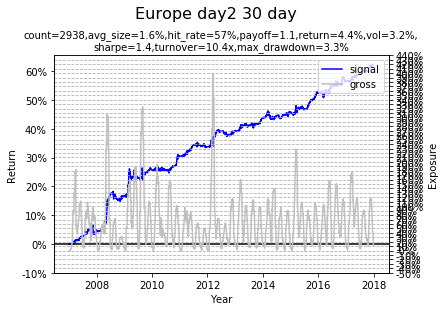

In [48]:
Europe_day2_30d.plot_account("Europe day2 30 day")

In [49]:
Asia_day2_30d=signal(fundamental_df=Asia,
                   price_df=Asia_price,
                   EAR_period=2,
                   long_criteria=((1,1000),(0.03,1000),None,None),
                   short_criteria=None,
                   holding=20,
                   start=pd.Timestamp(2007,1,1),
                   end=pd.Timestamp(2017,12,31))

In [50]:
_long_Asia,_short_Asia,_alpha_Asia,_portfolio_Asia=Asia_day2_30d.signal_account(stop=(8,8),
                                                           gross=(30,None),
                                                           index_df=abs_return_index_Asia.loc[["AS51 Index","HSI Index",
                                                                                                "TPX Index","KOSPI Index",
                                                                                                "MXSG Index","TAMSCI Index"]].T,
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.1,
                                                           capital=50)

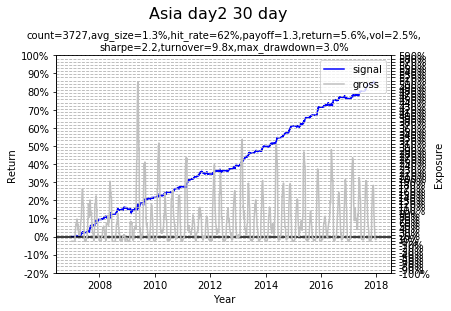

In [51]:
Asia_day2_30d.plot_account("Asia day2 30 day")

In [52]:
US_day2_30d=signal(fundamental_df=US,
                   price_df=US_price,
                   EAR_period=2,
                   long_criteria=((1,1000),(0.05,1000),None,None),
                   short_criteria=((-1000,-2),(-1000,-0.03),None,(5000,10000000)),
                   holding=30,
                   start=pd.Timestamp(2007,1,1),
                   end=pd.Timestamp(2017,12,31))

In [53]:
_long,_short,_alpha,_portfolio=US_day2_30d.signal_account(stop=(8,8),
                                                           gross=(30,15),
                                                           index_df=(0.5*abs_return_index_US.loc["SPX Index"]+\
                                                          0.5*abs_return_index_US.loc["RTY Index"]).to_frame("US_index"),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.1,
                                                           capital=100)

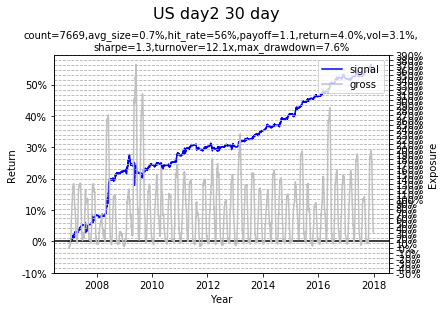

In [54]:
US_day2_30d.plot_account("US day2 30 day")

# 5 - Drawdown analysis

In [69]:
def drawdown_days(acct_curve,timestamp):
    dd=acct_curve-acct_curve.cummax()
    previous_high=acct_curve.loc[:timestamp].max()
    high_timestamp=acct_curve[acct_curve==previous_high].index[0]
    days=acct_curve.index.tolist().index(timestamp)-acct_curve.index.tolist().index(high_timestamp)
    return (high_timestamp,days)

In [70]:
def drawdown_df(portfolio_cache):
    drawdown=portfolio_cache[-1].iloc[:,-1].to_frame()
    drawdown.columns=["Index"]
    drawdown["Index vol"]=drawdown["Index"].rolling(30).std()
    drawdown["Portfolio"]=portfolio_cache[1].diff(1)
    drawdown["Account"]=portfolio_cache[1].copy()
    drawdown["Drawdown"]= drawdown["Account"]- drawdown["Account"].cummax()
    drawdown["Drawdown days"]= drawdown.apply(lambda x: drawdown_days(drawdown["Account"],x.name)[1],axis=1)
    drawdown["Drawdown start"]= drawdown.apply(lambda x: drawdown_days(drawdown["Account"],x.name)[0],axis=1)
    drawdown["Gross"]=np.abs(portfolio_cache[2]).sum(axis=1)
    return drawdown
    

In [71]:
def portfolio_drawdown_df(portfolio_cache,stop,multiple):
    portfolio_cache_list=list(portfolio_cache)
    orig_size=portfolio_cache_list[2]
    orig_account=portfolio_cache_list[1]
    dd=orig_account-orig_account.cummax()
    stop_evaluate=dd[dd.shift(1)<stop]
    adj_size=orig_size.apply(lambda x: x*multiple if x.name in stop_evaluate.index else x,axis=1)
    
    new_portfolio_cache=portfolio_cache_list.copy()
    new_portfolio_cache[2]=adj_size
    new_portfolio_cache[0]=adj_size.shift(1)*new_portfolio_cache[-1]
    new_portfolio_cache[1]=new_portfolio_cache[0].sum(axis=1).cumsum()
    return tuple(new_portfolio_cache)
    